In [1]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import DataLoader, random_split

(a)

In [2]:
dataDir = 'resized'               # The main data directory
classNames = os.listdir(dataDir)  # Each type of image can be found in its own subdirectory
numClass = len(classNames)        # Number of types = number of subdirectories
imageFiles = [[os.path.join(dataDir,classNames[i],x) for x in os.listdir(os.path.join(dataDir,classNames[i]))]
              for i in range(numClass)]                     # A nested list of filenames
numEach = [len(imageFiles[i]) for i in range(numClass)]     # A count of each type of image
imageFilesList = []               # Created an un-nested list of filenames
imageClass = []                   # The labels -- the type of each individual image in the list
for i in range(numClass):
    imageFilesList.extend(imageFiles[i])
    imageClass.extend([i]*numEach[i])
numTotal = len(imageClass)        # Total number of images
imageWidth, imageHeight = Image.open(imageFilesList[0]).size         # The dimensions of each image

print("There are",numTotal,"images in",numClass,"distinct categories")
print("Label names:",classNames)
print("Label counts:",numEach)
print("Image dimensions:",imageWidth,"x",imageHeight)

There are 58954 images in 6 distinct categories
Label names: ['HeadCT', 'CXR', 'BreastMRI', 'Hand', 'AbdomenCT', 'ChestCT']
Label counts: [10000, 10000, 8954, 10000, 10000, 10000]
Image dimensions: 64 x 64


In [3]:
from torchvision import datasets, transforms, io

#transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.Lambda(lambda x: x / 255) 
#])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

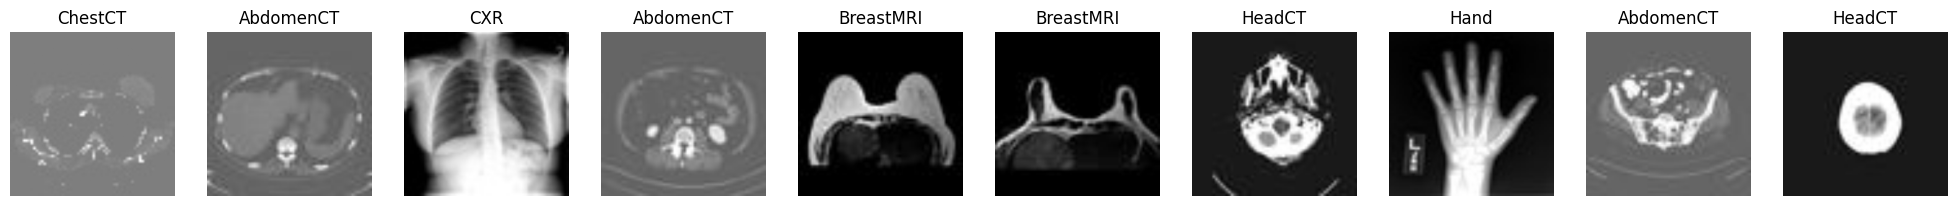

In [4]:
dataset = datasets.ImageFolder(root='resized', transform=transform)

def show_images(dataset):
    fig, axes = plt.subplots(1, 10, figsize=(25, 3))
    for ax in axes:
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        ax.imshow(img.permute(1, 2, 0))
        ax.set_title(dataset.classes[label]) 
        ax.axis('off')
    plt.show()

show_images(dataset)

In [5]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

(b)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [28]:
class MedCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(MedCNN, self).__init__()

        # conv1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # conv2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # FC layers
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
    
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
model = MedCNN(num_classes=6)

print(model)

MedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


(c)

In [29]:
from torch.utils.data import DataLoader

batch_size = 25

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [30]:
model = MedCNN(num_classes=6)
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [32]:
torch.cuda.is_available()

False

In [31]:
epochs = 10
train_losses, val_losses = [], []

for e in range(epochs):
    model.train()
    epochloss = 0.0

    for img, labels in train_loader:
        optim.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, labels)
        loss.backward()
        optim.step()
        epochloss += loss.item()
    train_losses.append(epochloss / len(train_loader))

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for img, labels in val_loader:
            outputs = model(img)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
    val_losses.append(val_running_loss / len(val_loader))

    print(f"Epoch {e+1}/{epochs}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

Epoch 1/10, Train Loss: 0.046947135879263836, Validation Loss: 0.01520268249799995


KeyboardInterrupt: 